<a href="https://colab.research.google.com/github/Pfannen/AI-Stock-Agent/blob/main/notebooks/stock_agent_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Test Section

In [ ]:
# Install required dependencies
!pip install yahoo_fin
!pip install requests_html

In [51]:
# Explore what's returned from yahoo_fin

from yahoo_fin.stock_info import get_data

amazon_daily = get_data(
    ticker="AMZN",
    start_date="12/04/2020",
    end_date="12/04/2021",
    index_as_date=True,
    interval="1d"
)

In [ ]:
amazon_daily

In [ ]:
# Make an array that stores tuples -> last 7 day closing prices, current day's closing price

LOOKBACK_INTERVAL = 7
amazon_model_data = []

# We need to loop through all of amazon_daily, grab previous 7 entries and current entry
for i in range(LOOKBACK_INTERVAL, len(amazon_daily)):
  current_close = amazon_daily['close'][i]
  previous_closes = amazon_daily['close'][i-LOOKBACK_INTERVAL:i]
  input_data_with_label = (previous_closes, current_close)
  amazon_model_data.append(input_data_with_label)

amazon_model_data[0]

In [58]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data = np.array(amazon_daily['close']).reshape(-1, 1)
scaler.fit(data)
data = scaler.transform(data).reshape(-1)
data = np.array(data).reshape(-1, 1)
scaler.inverse_transform(data).reshape(-1)
amazon_daily['close'] = data

## Modular Code Section

### Data Retrieval

In [64]:
# Functionize everything
# Step 1: Get data from yahoo_fin.stock
# Step 2: Create a scaler for the data and apply it
# Step 3: Split data into a tuple -> ([num_samples, lookback_interval, 1], [num_samples])
# Step 4: Create a data loader for train and test data

from yahoo_fin.stock_info import get_data
import numpy as np
from pandas import DataFrame
import math
import numpy
from sklearn.preprocessing import MinMaxScaler

def get_stock_data(ticker: str,
                  start_date: str,
                  end_date: str,
                  index_as_date: bool,
                  interval: str):
  stock_data = get_data(ticker, start_date, end_date, index_as_date, interval)
  stock_close_data = stock_data['close']
  return stock_close_data

def get_stock_data_frame(ticker: str,
                         start_date: str,
                         end_date: str,
                         index_as_date: bool,
                         interval: str):
  return get_data(ticker, start_date, end_date, index_as_date, interval)

def split_train_test(input_data, labels, train_size_percentage):
  last_train_idx = math.floor(len(labels) * train_size_percentage)

  train_data = input_data[:last_train_idx]
  train_labels = labels[:last_train_idx]
  test_data = input_data[last_train_idx:]
  test_labels = labels[last_train_idx:]

  return train_data, train_labels, test_data, test_labels

def generate_input_data(stock_data, lookback_interval):
  model_data = []
  model_labels = []

  for i in range(lookback_interval, len(stock_data)):
    current_close_price = stock_data[i]
    previous_closes = stock_data[i-lookback_interval:i]
    model_data.append(previous_closes)
    model_labels.append(current_close_price)

  return model_data, model_labels

def get_feature_data(data, lookback_interval, data_features: List[DataFeature]):
  feature_data = [ [ [] for _ in range(lookback_interval) ] for _ in range(len(data)) ]
  #features = [ [ [] for _ in range(12) ] for _ in range(12, n) ]
  model_labels = data['close'][:]

  removal_count = 0
  for data_feature in data_features:
    removal_count = max(removal_count, data_feature.compute_feature(data, feature_data))

  return feature_data[removal_count:], model_labels[removal_count:]

def get_scaler_for_data(stock_data):
  scaler = MinMaxScaler()
  stock_data = np.array(stock_data).reshape(-1, 1)
  scaler.fit(stock_data)
  return scaler

def apply_scaler_to_data(data, scaler, inverse=False):
  data = np.array(data).reshape(-1, 1)
  if inverse:
    data = scaler.inverse_transform(data).reshape(-1)
  else:
    data = scaler.transform(data).reshape(-1)
  return data

In [25]:
def get_trainable_data_from_ticker(ticker: str,
                                   start_date: str,
                                   end_date: str,
                                   index_as_date: bool,
                                   interval: str,
                                   lookback_interval:int,
                                   train_size_percentage: float,
                                   batch_size: int,
                                   num_workers: int):
  stock_data = get_stock_data(ticker,
                              start_date,
                              end_date,
                              index_as_date,
                              interval)
  scaler = get_scaler_for_data(stock_data)
  scaled_stock_data = apply_scaler_to_data(stock_data, scaler)
  input_data, labels = generate_input_data(scaled_stock_data, lookback_interval)
  train_X, train_y, test_X, test_y = split_train_test(input_data, labels, train_size_percentage)

  train_dataset, test_dataset = StockDataset(stock_data=[train_X, train_y]), StockDataset(stock_data=[test_X, test_y])

  train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
  test_dataloader = DataLoader(dataset=test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers)

  return train_dataloader, test_dataloader, stock_data, train_X, train_y, test_X, test_y, scaler

### Classes

#### Dataset

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
  def __init__(self, stock_data):
    self.data = stock_data

  def __len__(self):
    return len(self.data[1])

  def __getitem__(self, index):
    input = torch.tensor(self.data[0][index], dtype=torch.float32)
    label = torch.tensor(self.data[1][index], dtype=torch.float32)
    return input, label

#### StockModelData

In [27]:
# THIS IS AN OLD CLASS
# Let's create a class that will house everything we need to train and evaluate a model
# We need to pass in the stock info we want
# We need to store the original data, train and test data, the scaler used, and the dataloaders
# We also should provide methods for evaluating the model on the test data and subsequently have it plot predicted vs actual
class StockModelData():
  def __init__(self,
               ticker: str,
               start_date: str,
               end_date: str,
               index_as_date: bool,
               interval: str,
               lookback_interval: int,
               train_size_percentage: float,
               batch_size: int,
               device: str):
    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.index_as_date = index_as_date
    self.interval = interval
    self.lookback_interval = lookback_interval
    self.train_size_percentage = train_size_percentage
    self.batch_size = batch_size
    self.device = device

    # Get a lot of data that's used to train and predict on a model
    train_dataloader, test_dataloader, stock_data, train_X, train_y, test_X, test_y, scaler = get_trainable_data_from_ticker(ticker=ticker,
                                                                                                                            start_date=start_date,
                                                                                                                            end_date=end_date,
                                                                                                                            index_as_date=index_as_date,
                                                                                                                            interval=interval,
                                                                                                                            lookback_interval=lookback_interval,
                                                                                                                            train_size_percentage=train_size_percentage,
                                                                                                                            batch_size=batch_size,
                                                                                                                            num_workers=1)

    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.stock_data = stock_data
    self.train_X = train_X
    self.train_y = train_y
    self.test_X = test_X
    self.test_y = test_y
    self.scaler = scaler

  def get_original_stock_values(self, scaled_values):
    original_values = []
    for value_list in scaled_values:
      original_values.append(apply_scaler_to_data(value_list, self.scaler, True))
    return original_values

  def train_model(self, model, loss_fn, optimizer, epochs, device):
    results = train(model=model,
                    train_dataloader=self.train_dataloader,
                    test_dataloader=self.test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device)
    return results

  def plot_model_preds(self, model):
    train_preds, test_preds = get_model_preds(model, self.train_X, self.test_X, self.device)
    train_preds, test_preds = self.get_original_stock_values([train_preds, test_preds])

    # The model won't have predictions for the first lookback_interval indices because they're used for the first value's features
    stock_data = self.stock_data[self.lookback_interval:]
    cutoff_idx = len(train_preds)
    plot_stock_predictions(stock_data[:cutoff_idx], stock_data[cutoff_idx:], train_preds, test_preds)

  def get_model_preds_on_self(self, model, interval_pred_count):
    cur_lookback = [self.test_y[-self.lookback_interval:]]
    preds = []

    with torch.inference_mode():
      for i in range(interval_pred_count):
        input_tensor = torch.tensor(cur_lookback, dtype=torch.float32).to(self.device)
        cur_pred = model(input_tensor).item()
        preds.append(cur_pred)
        cur_lookback = [cur_lookback[0][1:]]
        cur_lookback[0].append(cur_pred)

      preds = apply_scaler_to_data(preds, self.scaler, True)
      plot_stock_predictions(train_data=self.stock_data,
                             test_data=preds,
                             train_preds=self.stock_data,
                             test_preds=preds)
      return preds

#### StockData

In [62]:
class StockData():
  def __init__(self,
               ticker: str,
               start_date: str,
               end_date: str,
               index_as_date: bool,
               interval: str):
    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.index_as_date = index_as_date
    self.interval = interval
    self.stock_data = get_stock_data_frame(ticker,
                                          start_date,
                                          end_date,
                                          index_as_date,
                                          interval)
    self.scaler = get_scaler_for_data(self.stock_data['close'])
    self.original_stock_closes = self.stock_data['close'][:]
    self.stock_data['close'] = self.get_scaled_stock_data()

  def get_stock_data(self):
    return self.stock_data

  def get_original_stock_closes(self):
    return self.original_stock_closes

  def get_scaled_stock_data(self, inverse_transform = False):
    return apply_scaler_to_data(self.stock_data['close'], self.scaler, inverse_transform)

  def get_scaled_data(self, data, inverse_transform = False):
    return apply_scaler_to_data(data, self.scaler, inverse_transform)

#### StockDataTransformer

In [63]:
class StockDataTransformer():
  def __init__(self,
               stock_data: StockData,
               feature_computators: List[DataFeature],
               lookback_interval: int,
               train_size_percentage: float,
               batch_size: int,
               device: str):
    self.stock_data = stock_data
    self.feature_computators = feature_computators
    self.lookback_interval = lookback_interval
    self.train_size_percentage = train_size_percentage
    self.batch_size = batch_size
    self.device = device

    input_data, labels = get_feature_data(data=stock_data.get_stock_data(),
                                          lookback_interval=lookback_interval,
                                          data_features=feature_computators)
    train_X, train_y, test_X, test_y = split_train_test(input_data=input_data,
                                                        labels=labels,
                                                        train_size_percentage=train_size_percentage)
    self.train_X = train_X
    self.train_y = train_y
    self.test_X = test_X
    self.test_y = test_y
    print(f"Test X Len: {len(test_X)} | test y Len: {len(test_y)}")

    train_dataset, test_dataset = StockDataset(stock_data=[train_X, train_y]), StockDataset(stock_data=[test_X, test_y])
    self.train_dataloader = DataLoader(dataset=train_dataset,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=1)
    self.test_dataloader = DataLoader(dataset=test_dataset,
                                      batch_size=batch_size,
                                      shuffle=False,
                                      num_workers=1)

  def get_dataloaders(self):
    return self.train_dataloader, self.test_dataloader


#### DataFeature

In [12]:
from abc import abstractmethod
import collections
from collections import deque
# Let's create an abstract class where all classes that want to add a feature to the data must inherit
class DataFeature():
  @abstractmethod
  def compute_feature(self, data, feature_data):
    """
    Computes a type of feature that gets added to each input given to a time-series predicting model

    Args:
      data: A list of closing prices
      feature_data: An array of the shape [intervals_predicting, lookback_interval, feature_count_per_interval]

    Returns:
      Modifies 'feature_data' directly
  """

##### Moving Average

In [65]:
class MovingAverageDataFeature(DataFeature):
  def __init__(self, moving_average_period):
    self.moving_average_period = moving_average_period

  def compute_feature(self, data, feature_data):
    # Use n for a shorter variable name
    n = self.moving_average_period
    lookback_count = len(feature_data[0])
    min_data_length = n + lookback_count
    if len(data) < min_data_length:
      print(f"There is not enough data! Need atleast {min_data_length} data points, but only got {len(data)}! (MA)")
      return
    else:
      print(f"Enough data! In order to work properly, there needs to be {n + lookback_count} intervals removed from the beginning of the feature data! (MA)")

    data = data['close']
    # For a moving average, we need to lookback moving_average_period values to get the current interval's MA
    # We use a deque for efficent removal from the left (could use a queue)
    cur_moving_average = deque()
    # Keep track of the current sum and current index
    cur_sum = 0
    cur_idx = 0

    def compute_moving_average_step(deduct = True):
      nonlocal cur_idx, cur_sum, data, cur_moving_average
      if cur_idx < len(data):
        value = data[cur_idx]
        if deduct:
          cur_sum -= cur_moving_average.popleft()
        cur_sum += value
        cur_idx += 1
        cur_moving_average.append(value)
      else:
        print(f"Index {cur_idx} is out of bounds for data of length {len(data)} (MA)")

    # Calculate the first moving average data point
    for _ in range(n):
      compute_moving_average_step(False)

    # cur_sum will store the moving average for the moving_average_period's interval (we will have to start adding at this offset)
    # let's fill up the first set of features with their MAs, then we can easily reuse the previous MAs for the next set of features
    initial_feature_set = feature_data[n + lookback_count]
    # The length of the feature set should be 'lookback_count'
    for i in range(len(initial_feature_set)):
      initial_feature_set[i].append(cur_sum / n)
      compute_moving_average_step()

    for i in range(n + lookback_count + 1, len(feature_data)):
      feature_set = feature_data[i]
      prev_feature_set = feature_data[i-1]
      for j in range(len(feature_set)-1):
        feature_set[j].append(prev_feature_set[j+1][-1])
      feature_set[-1].append(cur_sum / n)
      compute_moving_average_step()

    print(f"Returning {n + lookback_count}")
    return n + lookback_count

##### Lookback Closing Price

In [66]:
class ClosingPriceDataFeature(DataFeature):
  def compute_feature(self, data, feature_data):
    lookback_count = len(feature_data[0])

    if len(data) < lookback_count:
      print(f"There is not enough data! Need atleast {lookback_count} data points, but only got {len(data)}! (CP)")
      return
    else:
      print(f"Enough data! In order to work properly, there needs to be {lookback_count} intervals removed from the beginning of the feature data! (CP)")

    data = data['close']

    cur_idx = 0
    initial_feature_set = feature_data[lookback_count]
    for i in range(lookback_count):
      initial_feature_set[i].append(data[cur_idx])
      cur_idx += 1

    for i in range(lookback_count+1, len(feature_data)):
      feature_set = feature_data[i]
      prev_feature_set = feature_data[i-1]
      for j in range(lookback_count-1):
        feature_set[j].append(prev_feature_set[j+1][-1])
      feature_set[-1].append(data[cur_idx])
      cur_idx += 1

    return lookback_count

##### Volume

In [74]:
class VolumeDataFeature(DataFeature):
  def compute_feature(self, data, feature_data):
    lookback_count = len(feature_data[0])
    if len(data) < lookback_count:
      print(f"There is not enough data! Need atleast {lookback_count} data points, but only got {len(data)}! (CP)")
      return
    else:
      print(f"Enough data! In order to work properly, there needs to be {lookback_count} intervals removed from the beginning of the feature data! (CP)")

    volume_data = data['volume']

    cur_idx = 0
    initial_feature_set = feature_data[lookback_count]
    for i in range(lookback_count):
      initial_feature_set[i].append(volume_data[cur_idx])
      cur_idx += 1

    for i in range(lookback_count+1, len(feature_data)):
      feature_set = feature_data[i]
      prev_feature_set = feature_data[i-1]
      for j in range(lookback_count-1):
        feature_set[j].append(prev_feature_set[j+1][-1])
      feature_set[-1].append(volume_data[cur_idx])
      cur_idx += 1

    return lookback_count

### Train

In [15]:
"""
Contains functions for training and testing a PyTorch model.
"""
from typing import Dict, List, Tuple

import torch
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss = 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X).squeeze(dim=1)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)

  return train_loss

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss = 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X).squeeze(dim=1)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)

  return test_loss

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "test_loss": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      if epoch % 2 == 0:
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["test_loss"].append(test_loss)

  # Return the filled results at the end of the epochs
  return results

#### Train Model

In [16]:
def train_model_on_feature_data(model,
                                loss_fn,
                                optimizer,
                                epochs,
                                stock_data_transformer: StockDataTransformer):
  train_dataloader, test_dataloader = stock_data_transformer.get_dataloaders()
  device = stock_data_transformer.device
  results = train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epochs,
                  device=device)
  return results

#### Model Preds

In [82]:
def plot_model_preds(model,
                     stock_data_transformer: StockDataTransformer):
  train_X, test_X = stock_data_transformer.train_X, stock_data_transformer.test_X
  device = stock_data_transformer.device
  stock_data_obj = stock_data_transformer.stock_data

  train_preds, test_preds = get_model_preds(model, train_X, test_X, device)
  train_preds, test_preds = stock_data_obj.get_scaled_data(train_preds, True), stock_data_obj.get_scaled_data(test_preds, True)

  stock_data = stock_data_obj.get_original_stock_closes()
  value_diff = len(stock_data) - (len(train_preds) + len(test_preds))
  stock_data = stock_data[value_diff:]
  cutoff_idx = len(train_preds)
  plot_stock_predictions(stock_data[:cutoff_idx], stock_data[cutoff_idx:], train_preds, test_preds)

### Evaluating

In [18]:
# Get model predictions in numpy format suitable for plotting

def get_model_preds(model, train_data, test_data, device="cpu"):
  with torch.inference_mode():
    train_preds = model(torch.tensor(train_data, dtype=torch.float32).to(device)).squeeze(dim=1).cpu().detach().numpy()
    test_preds = model(torch.tensor(test_data, dtype=torch.float32).to(device)).squeeze(dim=1).cpu().detach().numpy()

    return train_preds, test_preds

In [19]:
# Create code to plot predictions
import pandas as pd
import matplotlib.pyplot as plt

def plot_stock_predictions(train_data, test_data, train_preds, test_preds):
  train_range = [i for i in range(len(train_data))]
  test_range = [i for i in range(len(train_data), len(train_data) + len(test_data))]

  plt.plot(train_range, train_data)
  plt.plot(train_range, train_preds)
  plt.plot(test_range, test_data)
  plt.plot(test_range, test_preds)
  plt.xlabel('Day')
  plt.ylabel('Close')
  plt.legend([
      'Actual Training Values',
      'Predicted Training Values',
      'Actual Testing Values',
      'Predicted Testing Values'
  ])
  plt.show()

### Models

In [20]:
import torch
from torch import nn

# Setup a basic linear model
class LinModel0(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
    super().__init__()
    self.lin_layer = nn.Sequential(
        nn.Linear(
            in_features=in_features,
            out_features=hidden_units
        ),
        nn.ReLU(),
        nn.Linear(
            in_features=hidden_units,
            out_features=hidden_units
        ),
        nn.ReLU(),
        nn.Linear(
            in_features=hidden_units,
            out_features=out_features
        )
    )

  def forward(self, x):
    return self.lin_layer(x)

In [21]:
import torch
from torch import nn

class LSTMModel(nn.Module):
  def __init__(self, in_features, hidden_units, out_features, stacked_layer_count, device):
    super().__init__()
    self.hidden_units = hidden_units
    self.stacked_layer_count = stacked_layer_count
    self.lstm = nn.LSTM(input_size=in_features,
                        hidden_size=hidden_units,
                        num_layers=stacked_layer_count,
                        batch_first=True)
    self.fc = nn.Linear(in_features=hidden_units,
                               out_features=out_features)
    self.device = device

  def forward(self, X):
    batch_size = len(X)
    # X = X.unsqueeze(dim=2)
    h0 = torch.zeros(self.stacked_layer_count, batch_size, self.hidden_units).to(device)
    c0 = torch.zeros(self.stacked_layer_count, batch_size, self.hidden_units).to(device)
    out, _ = self.lstm(X, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

## Model Eval Section

In [22]:
# Reusable training code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

loss_fn = nn.MSELoss()
EPOCHS = 10

LOOKBACK_INTERVAL = 7

cuda


In [19]:
GoogleStockData = StockModelData(ticker="GOOGL",
                                start_date="12/04/2015",
                                end_date="12/04/2020",
                                index_as_date=True,
                                interval="1d",
                                lookback_interval=LOOKBACK_INTERVAL,
                                train_size_percentage=0.8,
                                batch_size=32,
                                device=device)

In [51]:
five_ma = MovingAverageDataFeature(5)
twenty_ma = MovingAverageDataFeature(20)
closing_price_feature = ClosingPriceDataFeature()
# Make initial bare-bones feature array
n = len(GoogleStockData.stock_data)
features = [ [ [] for _ in range(12) ] for _ in range(12, n) ]
five_ma.compute_feature(GoogleStockData.stock_data, features)
twenty_ma.compute_feature(GoogleStockData.stock_data, features)
closing_price_feature.compute_feature(GoogleStockData.stock_data, features)

Enough data! In order to work properly, there needs to be 5 intervals removed from the beginning of the feature data!
Enough data! In order to work properly, there needs to be 20 intervals removed from the beginning of the feature data!
Enough data! In order to work properly, there needs to be 12 intervals removed from the beginning of the feature data!


12

In [ ]:
features[-2:]

In [ ]:
model1 = LSTMModel(in_features=1,
                   hidden_units=4,
                   out_features=1,
                   stacked_layer_count=1,
                   device=device).to(device)
optimizer1 = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

In [ ]:
GoogleStockData.train_model(model=model1,
                            loss_fn=loss_fn,
                            optimizer=optimizer1,
                            epochs=50,
                            device=device)
GoogleStockData.plot_model_preds(model=model1)

In [ ]:
GoogleStockData.plot_model_preds(model=model1)
res = GoogleStockData.get_model_preds_on_self(model1, 500)

In [ ]:
PaycomStockData = StockModelData(ticker="PAYC",
                                 start_date="05/01/2018",
                                 end_date="10/28/2023",
                                 index_as_date=True,
                                 interval="1d",
                                 lookback_interval=7,
                                 train_size_percentage=0.8,
                                 batch_size=32,
                                 device=device)

In [ ]:
paycomModel = LinModel0(in_features=7, hidden_units=10, out_features=1).to(device)
paycomOptimizer = torch.optim.SGD(params=paycomModel.parameters(),
                                 lr=0.1)

In [ ]:
PaycomStockData.train_model(model=paycomModel,
                            loss_fn=loss_fn,
                            optimizer=paycomOptimizer,
                            epochs=100,
                            device=device)
PaycomStockData.plot_model_preds(model=paycomModel)

In [ ]:
PaycomStockData.plot_model_preds(model=paycomModel)
res = PaycomStockData.get_model_preds_on_self(paycomModel, 500)

In [ ]:
data = torch.randn(16, 14)  # Example data, adjust dimensions as needed

# Reshape the data
lookback_interval = 7  # Example, adjust as needed
num_features_per_interval = 2  # Example, adjust as needed
reshaped_data = data.view(-1, lookback_interval, num_features_per_interval)

# Check the shape
print(reshaped_data.shape)
reshaped_data = reshaped_data.flatten(1, 2)
print(reshaped_data.shape)

torch.Size([16, 7, 2])
torch.Size([16, 14])


# Model Eval V2

In [68]:
# Get initial stock data
GoogleStockData = StockData(ticker="GOOGL",
                            start_date="12/04/2009",
                            end_date="12/04/2022",
                            index_as_date=True,
                            interval="1d")

In [84]:
# Get transformed stock data
GoogleTransformedData = StockDataTransformer(stock_data=GoogleStockData,
                                           feature_computators=[MovingAverageDataFeature(5),
                                                                MovingAverageDataFeature(20),
                                                                ClosingPriceDataFeature()],
                                           lookback_interval=7,
                                           train_size_percentage=0.8,
                                           batch_size=32,
                                           device=device)

Enough data! In order to work properly, there needs to be 12 intervals removed from the beginning of the feature data! (MA)
Returning 12
Enough data! In order to work properly, there needs to be 27 intervals removed from the beginning of the feature data! (MA)
Returning 27
Enough data! In order to work properly, there needs to be 7 intervals removed from the beginning of the feature data! (CP)
Test X Len: 649 | test y Len: 649


In [85]:
test_LSTM_model = LSTMModel(in_features=3,
                           hidden_units=4,
                           out_features=1,
                           stacked_layer_count=1,
                           device=device).to(device)
test_optimizer = torch.optim.SGD(params=test_LSTM_model.parameters(),
                            lr=0.1)

In [ ]:
res = train_model_on_feature_data(model=test_LSTM_model,
                                  loss_fn=loss_fn,
                                  optimizer=test_optimizer,
                                  epochs=100,
                                  stock_data_transformer=GoogleTransformedData)

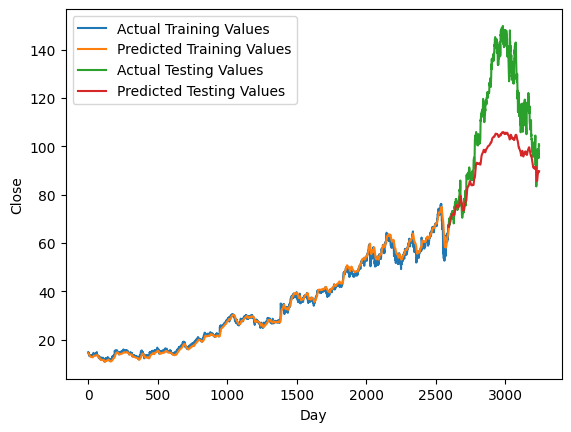

In [87]:
plot_model_preds(model=test_LSTM_model,
                 stock_data_transformer=GoogleTransformedData)